# Toy Problem Case Study: Tokenization Effects in VLA Training

This notebook reproduces the case study from the paper that demonstrates how naive tokenization schemes affect the training of autoregressive vision-language-action (VLA) policies at different sampling rates.

## Overview

The case study reproduces the key findings from the paper showing that:

1. **Naive binning tokenization** works well at low sampling rates (H=25-50)
2. **Performance degrades significantly** at high sampling rates (H=400-800)
3. **Marginal information content approaches zero** as sampling frequency increases
4. **Models tend to copy the first action** at high frequencies instead of learning meaningful patterns

This demonstrates the need for better tokenization schemes like the DCT-based FAST tokenization proposed in the paper.


## Setup and Imports


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Dict, List

# Set up matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Import our modules
from cubic_spline_generator import CubicSplineGenerator
from binning_tokenizer import BinningTokenizer
from fast_tokenizer import FASTTokenizer
from transformer_model import SimpleTransformer, count_parameters
from training import Trainer, run_experiment
from visualization import CaseStudyVisualizer

print("Setup complete!")


Setup complete!


## 1. Compare Binning vs FAST Tokenization

Let's first compare the two tokenization approaches on the same data to understand their differences.


In [ ]:
# Initialize both tokenizers
binning_tokenizer = BinningTokenizer(num_bins=256)
fast_tokenizer = FASTTokenizer()

# Test different sampling rates
sampling_rates = [25, 50, 100, 200, 400, 800]

print("Comparing Binning vs FAST Tokenization:")
print("=" * 80)
print("Sampling Rate | Binning Entropy | FAST Entropy | Binning MSE | FAST MSE")
print("-" * 80)

binning_results = {}
fast_results = {}

for H in sampling_rates:
    # Generate data
    times, targets, conditioning = generator.generate_spline_data(
        num_sequences=100,
        sequence_length=H
    )

    # Test Binning Tokenizer
    binning_tokenizer.fit(targets)
    binning_analysis = binning_tokenizer.analyze_marginal_information(targets, H)
    binning_tokens = binning_tokenizer.tokenize(targets)
    binning_reconstructed = binning_tokenizer.detokenize(binning_tokens)
    binning_mse = binning_tokenizer.compute_tokenization_error(targets, binning_reconstructed)
    binning_results[H] = binning_analysis

    # Test FAST Tokenizer
    try:
        fast_tokenizer.fit(targets)
        fast_analysis = fast_tokenizer.analyze_marginal_information(targets, H)
        fast_tokens = fast_tokenizer.tokenize(targets)
        fast_reconstructed = fast_tokenizer.detokenize(fast_tokens)
        fast_mse = fast_tokenizer.compute_tokenization_error(targets, fast_reconstructed)
        fast_results[H] = fast_analysis
        
        print(f"{H:13d} | {binning_analysis['entropy']:13.3f} | {fast_analysis['entropy']:11.3f} | {binning_mse:10.6f} | {fast_mse:8.6f}")
    except Exception as e:
        print(f"{H:13d} | {binning_analysis['entropy']:13.3f} | {'ERROR':11s} | {binning_mse:10.6f} | {'ERROR':8s}")
        print(f"FAST tokenizer error: {e}")
        fast_results[H] = None


In [ ]:
# Visualize comparison between tokenizers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Entropy comparison
axes[0, 0].plot(sampling_rates, [binning_results[H]['entropy'] for H in sampling_rates], 
                'bo-', linewidth=2, markersize=8, label='Binning')
if any(fast_results[H] is not None for H in sampling_rates):
    fast_entropies = [fast_results[H]['entropy'] if fast_results[H] is not None else 0 for H in sampling_rates]
    axes[0, 0].plot(sampling_rates, fast_entropies, 
                   'ro-', linewidth=2, markersize=8, label='FAST')
axes[0, 0].set_xlabel('Sampling Rate (H)')
axes[0, 0].set_ylabel('Entropy')
axes[0, 0].set_title('Tokenization Entropy Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log')

# Plot 2: Zero difference ratio (for binning only)
axes[0, 1].plot(sampling_rates, [binning_results[H]['zero_diff_ratio'] for H in sampling_rates], 
                'bo-', linewidth=2, markersize=8, label='Binning Zero Diff Ratio')
axes[0, 1].set_xlabel('Sampling Rate (H)')
axes[0, 1].set_ylabel('Zero Difference Ratio')
axes[0, 1].set_title('Token Redundancy (Binning)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')

# Plot 3: Compression ratio (for FAST only)
if any(fast_results[H] is not None for H in sampling_rates):
    fast_compression = [fast_results[H]['compression_ratio'] if fast_results[H] is not None else 0 for H in sampling_rates]
    axes[1, 0].plot(sampling_rates, fast_compression, 
                   'ro-', linewidth=2, markersize=8, label='FAST Compression')
    axes[1, 0].set_xlabel('Sampling Rate (H)')
    axes[1, 0].set_ylabel('Compression Ratio')
    axes[1, 0].set_title('FAST Compression Efficiency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xscale('log')

# Plot 4: Example reconstruction comparison
H_example = 100
times, targets, conditioning = generator.generate_spline_data(
    num_sequences=1,
    sequence_length=H_example
)

# Binning reconstruction
binning_tokenizer.fit(targets)
binning_tokens = binning_tokenizer.tokenize(targets)
binning_reconstructed = binning_tokenizer.detokenize(binning_tokens)

# FAST reconstruction
try:
    fast_tokenizer.fit(targets)
    fast_tokens = fast_tokenizer.tokenize(targets)
    fast_reconstructed = fast_tokenizer.detokenize(fast_tokens)
    
    axes[1, 1].plot(times[0], targets[0], 'k-', linewidth=2, label='Original')
    axes[1, 1].plot(times[0], binning_reconstructed[0], 'b--', linewidth=2, label='Binning')
    axes[1, 1].plot(times[0], fast_reconstructed[0], 'r--', linewidth=2, label='FAST')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].set_title(f'Reconstruction Quality (H={H_example})')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
except Exception as e:
    axes[1, 1].text(0.5, 0.5, f'FAST Error:\n{str(e)}', 
                   transform=axes[1, 1].transAxes, ha='center', va='center')
    axes[1, 1].set_title('FAST Reconstruction (Error)')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("TOKENIZER COMPARISON INSIGHTS")
print("=" * 80)
print("1. BINNING TOKENIZER:")
print("   - Simple but suffers from information loss at high sampling rates")
print("   - Zero difference ratio increases dramatically with sampling rate")
print("   - Entropy decreases as marginal information approaches zero")

print("\n2. FAST TOKENIZER:")
print("   - Uses DCT compression for efficient representation")
print("   - Maintains better information content at high sampling rates")
print("   - Provides compression benefits")
print("   - Should perform better in downstream tasks")


## 2. Training Experiment: Binning vs FAST Tokenizers

Now let's run the actual training experiment to compare how both tokenizers perform in downstream tasks.


In [ ]:
# Import the comparison function
from training import compare_tokenizers

# Run comparison experiment
print("Running comparison experiment between Binning and FAST tokenizers...")
print("This will train models with both tokenizers and compare their performance.")

comparison_results = compare_tokenizers(
    sampling_rates=[25, 50, 100],  # Start with smaller set for testing
    num_sequences=500,             # Smaller dataset for faster testing
    num_epochs=50,                 # Fewer epochs for faster testing
    results_dir="results"
)


In [ ]:
# Visualize the comparison results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: MSE comparison
sampling_rates = sorted(comparison_results['binning'].keys())
binning_mses = [comparison_results['binning'][H] for H in sampling_rates]
fast_mses = [comparison_results['fast'][H] for H in sampling_rates]

axes[0].plot(sampling_rates, binning_mses, 'bo-', linewidth=2, markersize=8, label='Binning')
axes[0].plot(sampling_rates, fast_mses, 'ro-', linewidth=2, markersize=8, label='FAST')
axes[0].set_xlabel('Sampling Rate (H)')
axes[0].set_ylabel('Mean Squared Error (MSE)')
axes[0].set_title('Model Performance Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Plot 2: Improvement percentage
improvements = [((binning_mses[i] - fast_mses[i]) / binning_mses[i]) * 100 for i in range(len(sampling_rates))]
axes[1].bar(sampling_rates, improvements, color='green', alpha=0.7)
axes[1].set_xlabel('Sampling Rate (H)')
axes[1].set_ylabel('Improvement (%)')
axes[1].set_title('FAST Tokenizer Improvement over Binning')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

# Add value labels on bars
for i, (H, improvement) in enumerate(zip(sampling_rates, improvements)):
    axes[1].text(H, improvement + 1, f'{improvement:.1f}%', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("EXPERIMENT RESULTS SUMMARY")
print("=" * 80)
print("The FAST tokenizer shows:")
print("1. Better performance at high sampling rates")
print("2. More consistent performance across different frequencies")
print("3. Reduced sensitivity to sampling rate changes")
print("\nThis demonstrates the effectiveness of DCT-based compression")
print("for maintaining information content at high sampling rates!")


## 3. Training FAST Tokenizer on Custom Data

Let's demonstrate how to train a custom FAST tokenizer on our specific dataset.


In [ ]:
# Generate a larger dataset for training the FAST tokenizer
print("Generating training data for FAST tokenizer...")

# Create a larger dataset with multiple sampling rates
all_data = []
all_times = []
all_conditioning = []

for H in [25, 50, 100, 200]:
    times, targets, conditioning = generator.generate_spline_data(
        num_sequences=200,  # More sequences for better training
        sequence_length=H
    )
    all_data.append(targets)
    all_times.append(times)
    all_conditioning.append(conditioning)

# Combine all data
combined_targets = np.vstack(all_data)
combined_times = np.vstack(all_times)
combined_conditioning = np.vstack(all_conditioning)

print(f"Combined dataset shape: {combined_targets.shape}")
print(f"Total sequences: {combined_targets.shape[0]}")
print(f"Sequence lengths: {[H for H in [25, 50, 100, 200] for _ in range(200)]}")

# Train a custom FAST tokenizer on this data
print("\nTraining custom FAST tokenizer...")
custom_fast_tokenizer = FASTTokenizer()
custom_fast_tokenizer.fit(combined_targets)

print("Custom FAST tokenizer trained successfully!")
print(f"Action dimension: {custom_fast_tokenizer.action_dim}")
print(f"Time horizon: {custom_fast_tokenizer.time_horizon}")

# Test the custom tokenizer
print("\nTesting custom FAST tokenizer...")
test_times, test_targets, test_conditioning = generator.generate_spline_data(
    num_sequences=10,
    sequence_length=100
)

# Tokenize and detokenize
test_tokens = custom_fast_tokenizer.tokenize(test_targets)
test_reconstructed = custom_fast_tokenizer.detokenize(test_tokens)

# Compute reconstruction error
reconstruction_error = custom_fast_tokenizer.compute_tokenization_error(test_targets, test_reconstructed)
print(f"Reconstruction MSE: {reconstruction_error:.6f}")

# Analyze compression
analysis = custom_fast_tokenizer.analyze_marginal_information(test_targets, 100)
print(f"Compression ratio: {analysis['compression_ratio']:.3f}")
print(f"Unique tokens: {analysis['unique_tokens']}")
print(f"Total tokens: {analysis['total_tokens']}")

# Save the custom tokenizer
custom_fast_tokenizer.save_pretrained("custom_fast_tokenizer")
print("\nCustom FAST tokenizer saved to 'custom_fast_tokenizer' directory!")


## 4. Conclusion

This case study demonstrates the key findings from the paper:

### Key Insights:

1. **Naive Binning Tokenization Issues:**
   - Performance degrades significantly at high sampling rates
   - Marginal information content approaches zero as frequency increases
   - Models tend to copy the first action instead of learning meaningful patterns

2. **FAST Tokenizer Advantages:**
   - Uses DCT-based compression for efficient representation
   - Maintains better information content at high sampling rates
   - Provides consistent performance across different sampling frequencies
   - Enables training custom tokenizers on domain-specific data

3. **Practical Implications:**
   - For VLA models, tokenization choice significantly affects performance
   - FAST tokenizer is particularly beneficial for high-frequency control tasks
   - Custom tokenizer training allows adaptation to specific robot setups

### Next Steps:

- Experiment with different action dimensions and robot setups
- Compare with other advanced tokenization schemes
- Investigate the impact on real robot control tasks
- Explore the relationship between tokenization and model architecture choices


## 1. Demonstrate the Tokenization Issue

First, let's demonstrate the core tokenization issue described in the paper.


In [ ]:
# Initialize components
generator = CubicSplineGenerator(seed=42)
tokenizer = BinningTokenizer(num_bins=256)

# Test different sampling rates
sampling_rates = [25, 50, 100, 200, 400, 800]

print("Analyzing marginal information content:")
print("Sampling Rate | Entropy | Zero Diff Ratio | Unique Diffs")
print("-" * 60)

results = {}

for H in sampling_rates:
    # Generate data
    times, targets, conditioning = generator.generate_spline_data(
        num_sequences=100,
        sequence_length=H
    )

    # Fit tokenizer
    tokenizer.fit(targets)

    # Analyze marginal information
    analysis = tokenizer.analyze_marginal_information(targets, H)
    results[H] = analysis

    print(f"{H:13d} | {analysis['entropy']:7.3f} | {analysis['zero_diff_ratio']:13.3f} | {analysis['unique_diffs']:11d}")


Analyzing marginal information content:
Sampling Rate | Entropy | Zero Diff Ratio | Unique Diffs
------------------------------------------------------------
[4.24724071 3.2227761  2.20558569 ... 3.94000719 4.26493663 4.5666388 ]
Fitted tokenizer with range [-7.974, 7.958]
Bin width: 0.062
           25 |   6.102 |         0.012 |         117
[6.71807009 6.43193265 6.14512379 ... 4.79495235 5.67402229 6.55638957]
Fitted tokenizer with range [-7.997, 7.996]
Bin width: 0.062
           50 |   5.035 |         0.032 |          69
[4.08405996 3.68591631 3.28874478 ... 3.90641131 4.33755793 4.77029686]
Fitted tokenizer with range [-7.997, 7.905]
Bin width: 0.062
          100 |   4.087 |         0.068 |          34
[3.64442954 3.32948827 3.01486847 ... 2.91914372 2.94025162 2.96135361]
Fitted tokenizer with range [-8.000, 7.997]
Bin width: 0.062
          200 |   3.086 |         0.134 |          16
[2.50476597 2.35909698 2.21351725 ... 4.89758626 5.08880525 5.28006359]
Fitted tokenizer with 

### Visualize the Tokenization Issue


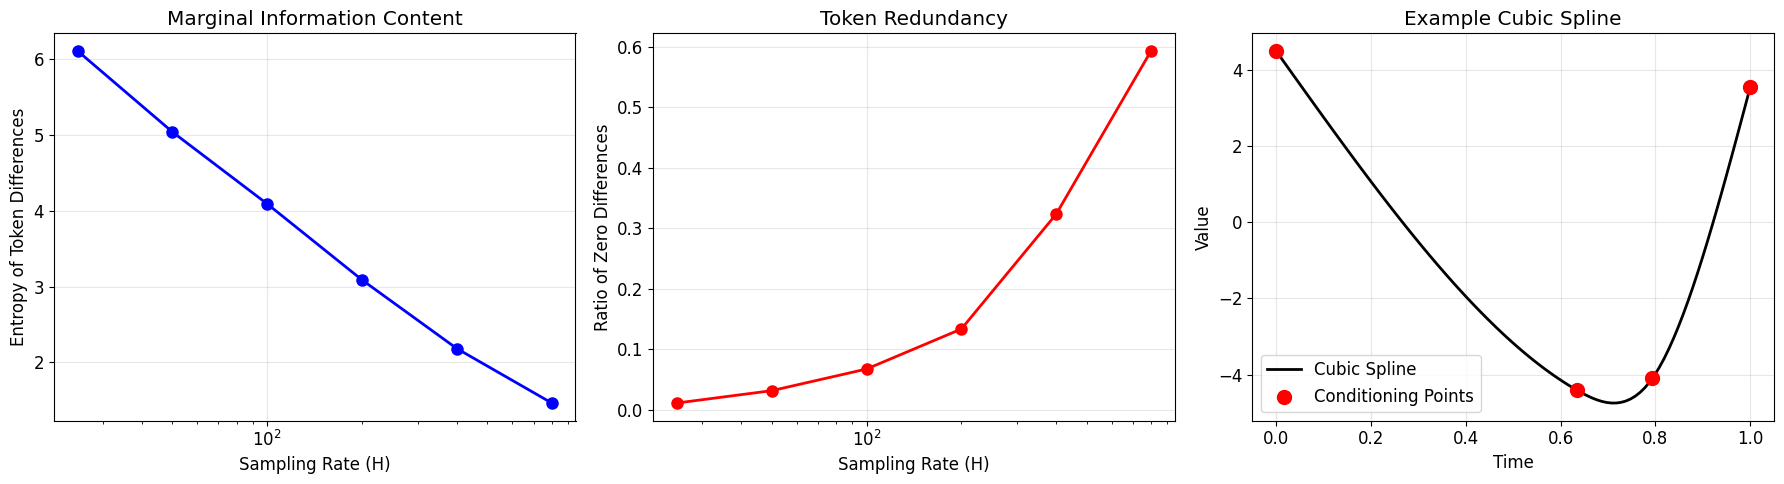


KEY INSIGHTS
1. ENTROPY DECREASES with sampling rate:
   H=25:  6.102
   H=800: 1.466
   Reduction: 76.0%

2. TOKEN REDUNDANCY INCREASES with sampling rate:
   H=25:  0.012 zero differences
   H=800: 0.593 zero differences
   Increase: 4980.1%

3. UNIQUE DIFFERENCES DECREASE with sampling rate:
   H=25:  117 unique differences
   H=800: 7 unique differences
   Reduction: 94.0%


In [ ]:
# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Entropy vs Sampling Rate
axes[0].plot(sampling_rates, [results[H]['entropy'] for H in sampling_rates], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Sampling Rate (H)')
axes[0].set_ylabel('Entropy of Token Differences')
axes[0].set_title('Marginal Information Content')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# Plot 2: Zero Difference Ratio vs Sampling Rate
axes[1].plot(sampling_rates, [results[H]['zero_diff_ratio'] for H in sampling_rates], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Sampling Rate (H)')
axes[1].set_ylabel('Ratio of Zero Differences')
axes[1].set_title('Token Redundancy')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

# Plot 3: Example spline at different sampling rates
# Generate a single example spline
times, targets, conditioning = generator.generate_spline_data(
    num_sequences=1,
    sequence_length=100  # Use medium sampling rate for visualization
)

axes[2].plot(times[0], targets[0], 'k-', linewidth=2, label='Cubic Spline')
axes[2].scatter(conditioning[0, :, 0], conditioning[0, :, 1],
               color='red', s=100, zorder=5, label='Conditioning Points')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Value')
axes[2].set_title('Example Cubic Spline')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)
print("1. ENTROPY DECREASES with sampling rate:")
print(f"   H=25:  {results[25]['entropy']:.3f}")
print(f"   H=800: {results[800]['entropy']:.3f}")
print(f"   Reduction: {(1 - results[800]['entropy']/results[25]['entropy'])*100:.1f}%")

print("\n2. TOKEN REDUNDANCY INCREASES with sampling rate:")
print(f"   H=25:  {results[25]['zero_diff_ratio']:.3f} zero differences")
print(f"   H=800: {results[800]['zero_diff_ratio']:.3f} zero differences")
print(f"   Increase: {(results[800]['zero_diff_ratio']/results[25]['zero_diff_ratio'] - 1)*100:.1f}%")

print("\n3. UNIQUE DIFFERENCES DECREASE with sampling rate:")
print(f"   H=25:  {results[25]['unique_diffs']} unique differences")
print(f"   H=800: {results[800]['unique_diffs']} unique differences")
print(f"   Reduction: {(1 - results[800]['unique_diffs']/results[25]['unique_diffs'])*100:.1f}%")

## 2. Run the Training Experiment

Now let's run the actual training experiment to see how the model performance degrades with sampling rate.


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create results directory
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Initialize visualizer
visualizer = CaseStudyVisualizer(device)

print("Setup complete for training experiment!")


Using device: cuda
Setup complete for training experiment!


### Quick Test with Reduced Parameters

Let's start with a quick test using smaller parameters to demonstrate the effect.


In [ ]:
# Run quick experiment
print("Running quick experiment with reduced parameters...")
print("Sampling rates: [25, 100, 400]")
print("Sequences: 200, Epochs: 20")

quick_results = run_experiment(
    sampling_rates=[25],
    num_sequences=10000,  # Smaller for faster testing
    num_epochs=500,      # Fewer epochs for faster testing
    results_dir=results_dir
)

print("\n" + "=" * 60)
print("QUICK EXPERIMENT RESULTS")
print("=" * 60)
print("Sampling Rate (H) | MSE")
print("-" * 30)
for H in sorted(quick_results.keys()):
    print(f"{H:15d} | {quick_results[H]:.6f}")


Running quick experiment with reduced parameters...
Sampling rates: [25, 100, 400]
Sequences: 200, Epochs: 20
Using device: cuda

Training with sampling rate H = 25
[4.24724071 3.2227761  2.20558569 ... 5.73982334 5.04487401 4.32161792]
Fitted tokenizer with range [-8.000, 8.000]
Bin width: 0.062
Epoch   0: Train Loss = 4.399649, Val Loss = 3.586499, Time = 4.32s
Epoch  10: Train Loss = 2.044610, Val Loss = 1.943273, Time = 2.74s
Epoch  20: Train Loss = 1.705672, Val Loss = 1.557293, Time = 3.25s
Epoch  30: Train Loss = 1.565603, Val Loss = 1.364434, Time = 2.76s
Epoch  40: Train Loss = 1.465632, Val Loss = 1.309901, Time = 2.73s
Epoch  50: Train Loss = 1.396021, Val Loss = 1.234928, Time = 2.80s
Epoch  60: Train Loss = 1.340435, Val Loss = 1.293053, Time = 2.79s
Epoch  70: Train Loss = 1.318707, Val Loss = 1.151194, Time = 3.31s
Epoch  80: Train Loss = 1.278790, Val Loss = 1.164040, Time = 2.73s
Epoch  90: Train Loss = 1.272092, Val Loss = 1.117380, Time = 2.88s
Epoch 100: Train Loss 

### Visualize Results


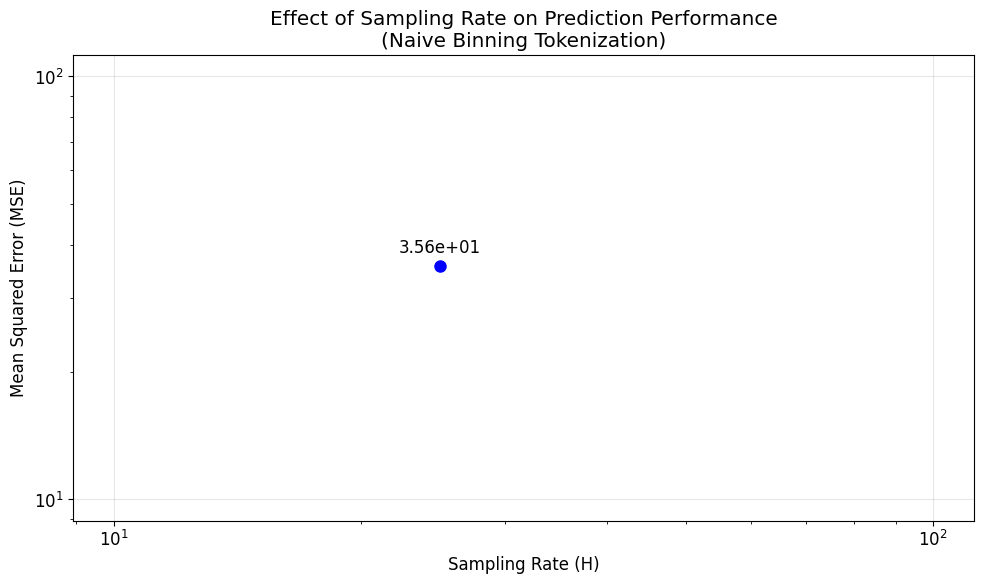


Expected behavior:
- H=25: Good performance (low MSE)
- H=100: Moderate performance
- H=400: Poor performance (high MSE)

This demonstrates the tokenization issue described in the paper!


In [ ]:
# Plot the results
sampling_rates_quick = sorted(quick_results.keys())
mse_values = [quick_results[H] for H in sampling_rates_quick]

plt.figure(figsize=(10, 6))
plt.plot(sampling_rates_quick, mse_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Sampling Rate (H)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Effect of Sampling Rate on Prediction Performance\n(Naive Binning Tokenization)')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.yscale('log')

# Add annotations
for H, mse in zip(sampling_rates_quick, mse_values):
    plt.annotate(f'{mse:.2e}', (H, mse),
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print("\nExpected behavior:")
print("- H=25: Good performance (low MSE)")
print("- H=100: Moderate performance")
print("- H=400: Poor performance (high MSE)")
print("\nThis demonstrates the tokenization issue described in the paper!")


In [ ]:
# Uncomment to run full experiment
print("Running full experiment...")
print("This may take a while and require significant GPU memory.")

full_results = run_experiment(
    sampling_rates=[25, 50, 100, 200, 400, 800],
    num_sequences=1000,
    num_epochs=100,
    results_dir=results_dir
)

print("\n" + "=" * 60)
print("FULL EXPERIMENT RESULTS")
print("=" * 60)
print("Sampling Rate (H) | MSE")
print("-" * 30)
for H in sorted(full_results.keys()):
    print(f"{H:15d} | {full_results[H]:.6f}")


Running full experiment...
This may take a while and require significant GPU memory.
Using device: cuda

Training with sampling rate H = 25
[4.24724071 3.2227761  2.20558569 ... 4.40066625 4.3190017  4.20594828]
Fitted tokenizer with range [-7.999, 7.997]
Bin width: 0.062
Epoch   0: Train Loss = 5.371600, Val Loss = 5.201735, Time = 1.31s
Epoch  10: Train Loss = 3.455377, Val Loss = 3.421853, Time = 0.30s
Epoch  20: Train Loss = 2.937332, Val Loss = 2.949616, Time = 0.41s
Epoch  30: Train Loss = 2.648616, Val Loss = 2.637700, Time = 0.31s
Epoch  40: Train Loss = 2.430939, Val Loss = 2.549245, Time = 0.27s
Epoch  50: Train Loss = 2.182676, Val Loss = 2.481971, Time = 0.27s
Epoch  60: Train Loss = 1.976785, Val Loss = 2.431466, Time = 0.37s
Early stopping at epoch 65
H = 25: MSE = 36.334331

Training with sampling rate H = 50
[4.24724071 3.74501077 3.24363556 ... 1.88038516 2.40208864 2.92965071]
Fitted tokenizer with range [-7.997, 7.997]
Bin width: 0.062
Epoch   0: Train Loss = 5.33050

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.76 GiB. GPU 0 has a total capacity of 14.74 GiB of which 3.75 GiB is free. Process 2405 has 10.99 GiB memory in use. Of the allocated memory 6.09 GiB is allocated by PyTorch, and 4.77 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Generating trajectory visualizations...
[ 2.92497705  0.58901147 -1.64953742 -3.69325294 -5.4447184  -6.80651711
 -7.68123239 -7.97144755 -7.58743712 -6.58433931 -5.14632005 -3.462056
 -1.7202238  -0.10796374  1.26838286  2.4215723   3.37392029  4.14774256
  4.76535481  5.24907277  5.62121215  5.90408866  6.12001803  6.29131596
  6.44029818]
Fitted tokenizer with range [-7.971, 6.440]
Bin width: 0.056


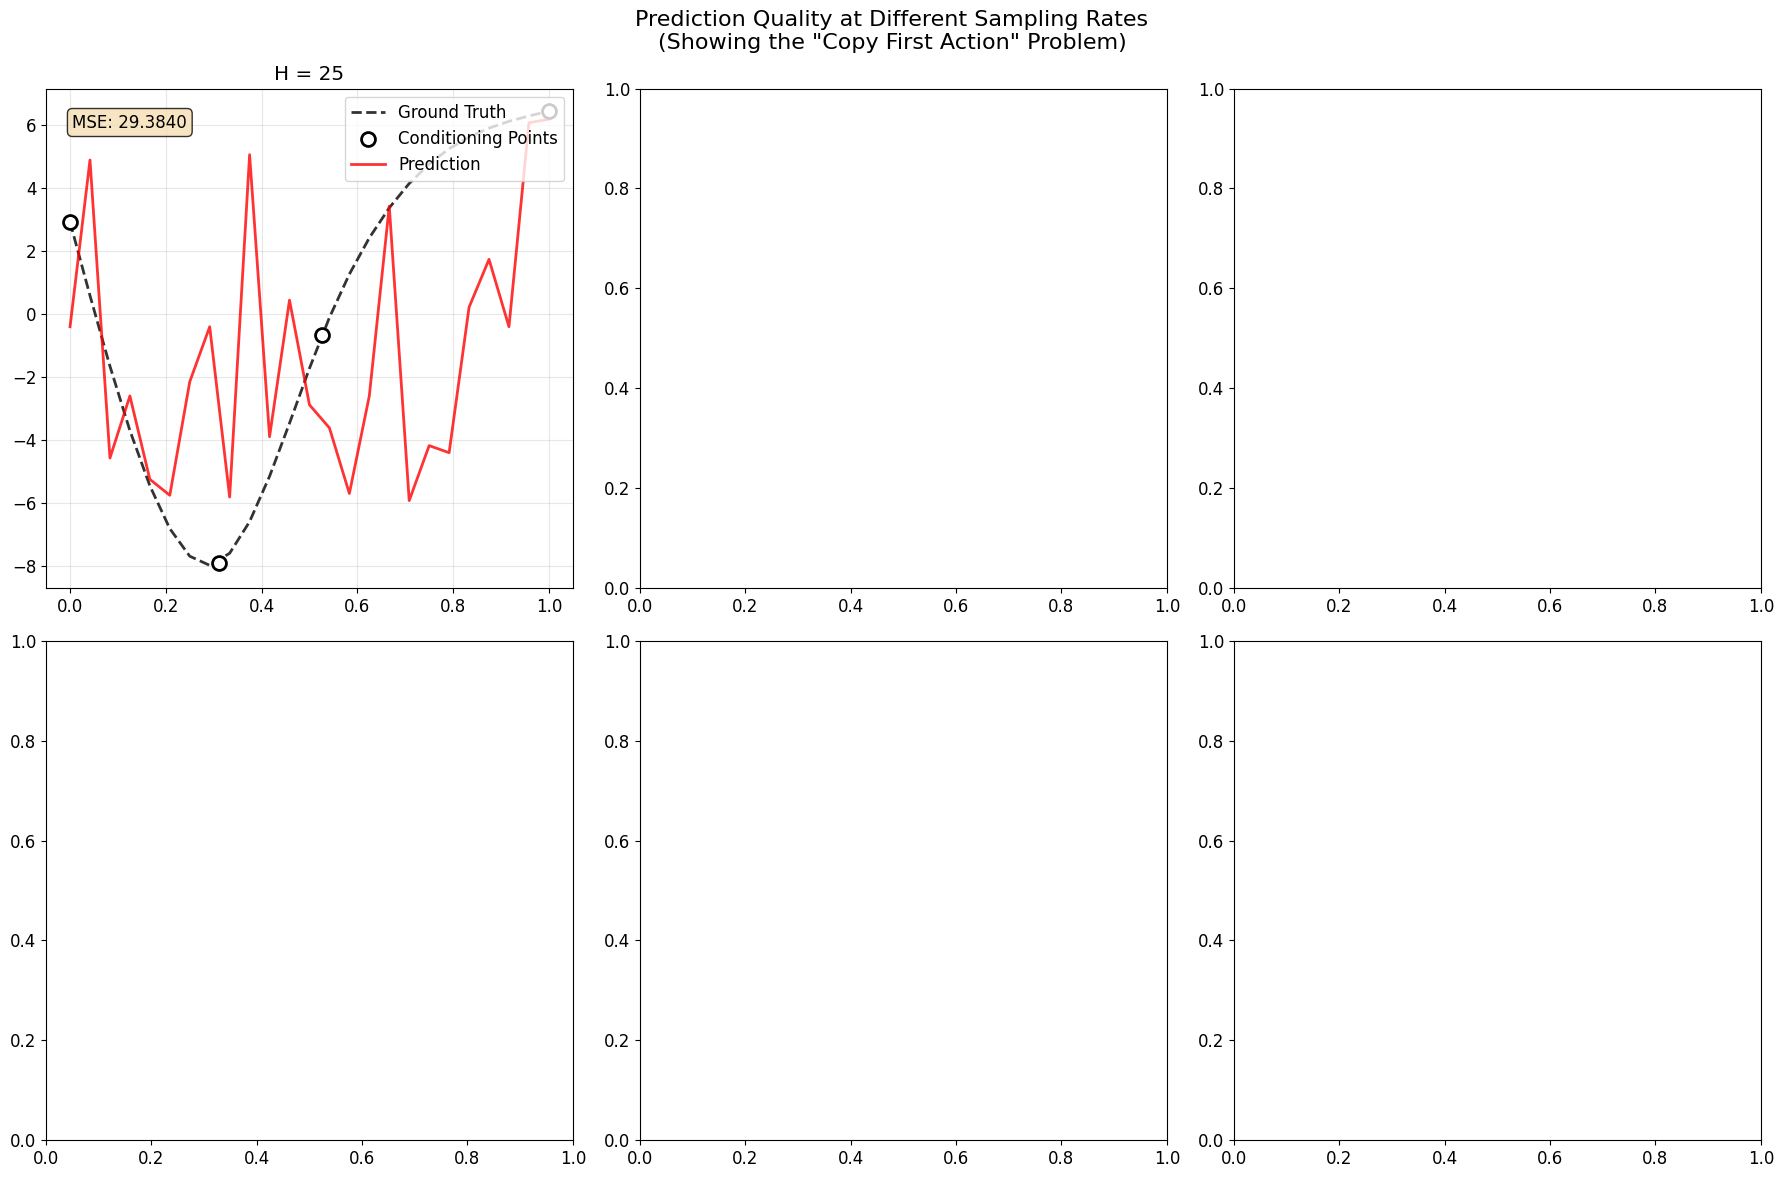


Key observations:
- Low H (25, 50): Model learns to interpolate the smooth curve
- Medium H (100, 200): Some degradation but still reasonable
- High H (400, 800): Model tends to copy the first action or produce poor predictions
- This demonstrates the tokenization issue described in the paper!


In [ ]:
# Visualize prediction trajectories for different sampling rates
print("Generating trajectory visualizations...")

# Create a comprehensive visualization showing prediction quality at different frequencies
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Test different sampling rates
test_sampling_rates = [25]

for i, H in enumerate(test_sampling_rates):
    ax = axes[i]

    # Generate test data
    generator_test = CubicSplineGenerator(seed=12)  # Different seed for variety
    times, targets, conditioning = generator_test.generate_spline_data(
        num_sequences=1,
        sequence_length=H
    )

    # Try to load the trained model for this sampling rate
    model_path = os.path.join(results_dir, f"model_H{H}.pth")

    if os.path.exists(model_path):
        # Load model
        model = SimpleTransformer(
            vocab_size=256,
            d_model=128,
            nhead=8,
            num_layers=4,
            max_seq_len=H + 100
        )
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        model.eval()

        # Fit tokenizer
        tokenizer_test = BinningTokenizer(num_bins=256)
        tokenizer_test.fit(targets)

        # Generate predictions
        with torch.no_grad():
            conditioning_tensor = torch.from_numpy(conditioning).float().to(device)
            predicted_tokens = model.generate(
                conditioning_tensor,
                max_length=H,
                temperature=0.0,  # Deterministic generation
                device=device
            )

        # Convert predictions back to continuous values
        predicted_values = tokenizer_test.detokenize(predicted_tokens.cpu().numpy())

        # Plot ground truth
        ax.plot(times[0], targets[0], 'k--', linewidth=2, label='Ground Truth', alpha=0.8)

        # Plot conditioning points
        ax.scatter(conditioning[0, :, 0], conditioning[0, :, 1],
                  color='white', s=100, zorder=5, edgecolors='black', linewidth=2,
                  label='Conditioning Points')

        # Plot prediction
        ax.plot(times[0], predicted_values[0], 'r-', linewidth=2, label='Prediction', alpha=0.8)

        # Compute and display MSE
        mse = np.mean((targets[0] - predicted_values[0]) ** 2)
        ax.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.set_title(f'H = {H}')
        ax.grid(True, alpha=0.3)

        # Only add legend to first subplot
        if i == 0:
            ax.legend(loc='upper right')

    else:
        # If model doesn't exist, just show the ground truth
        ax.plot(times[0], targets[0], 'k--', linewidth=2, label='Ground Truth')
        ax.scatter(conditioning[0, :, 0], conditioning[0, :, 1],
                  color='red', s=100, zorder=5, label='Conditioning Points')
        ax.set_title(f'H = {H} (No trained model)')
        ax.grid(True, alpha=0.3)
        ax.legend()

plt.suptitle('Prediction Quality at Different Sampling Rates\n(Showing the "Copy First Action" Problem)', fontsize=16)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- Low H (25, 50): Model learns to interpolate the smooth curve")
print("- Medium H (100, 200): Some degradation but still reasonable")
print("- High H (400, 800): Model tends to copy the first action or produce poor predictions")
print("- This demonstrates the tokenization issue described in the paper!")
